# Q2.1

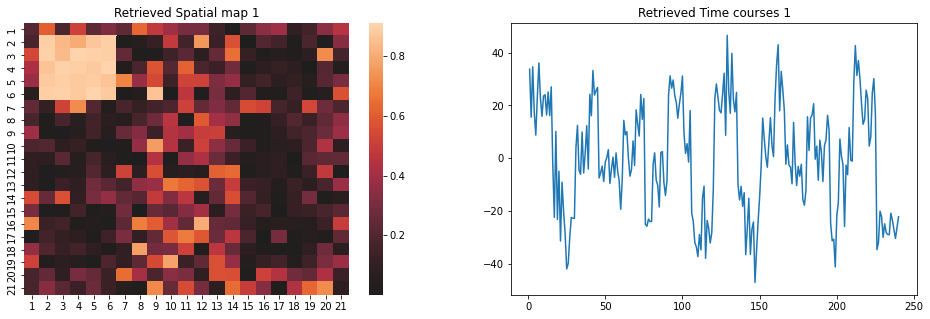

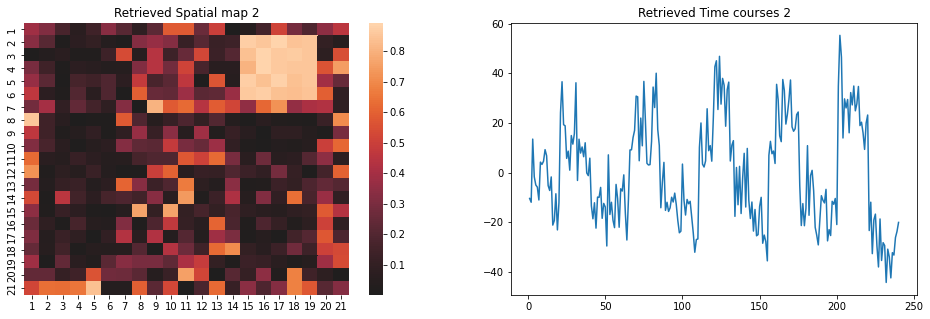

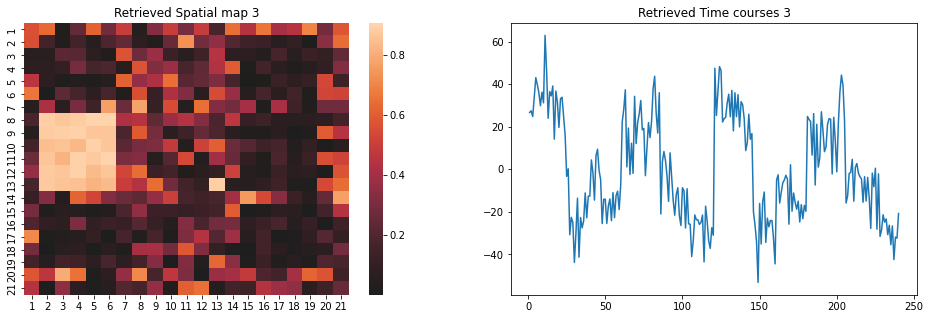

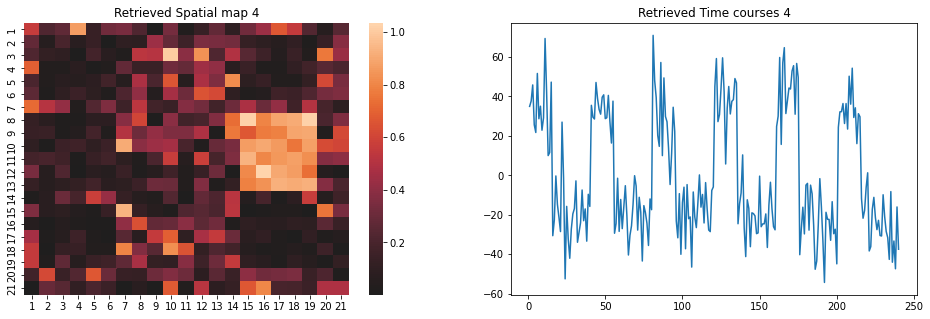

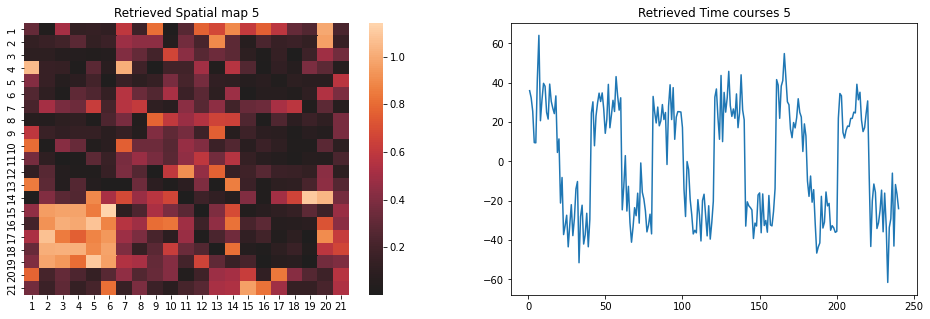

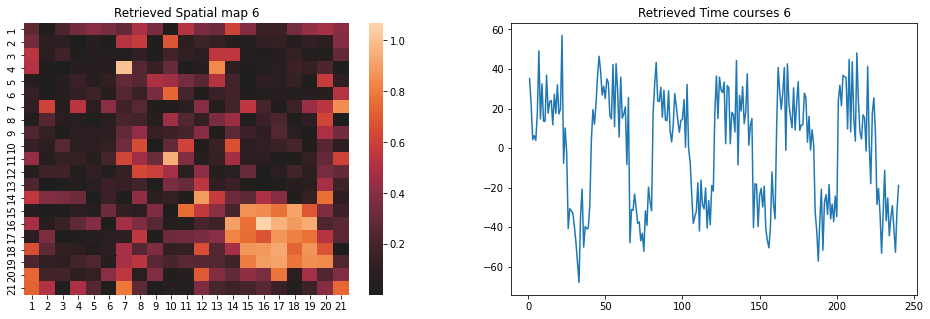

In [201]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

D = np.genfromtxt('data/TC.csv', delimiter=',')
X = np.genfromtxt('data/X.csv', delimiter=',')
SM = np.genfromtxt('data/SM.csv', delimiter=',')

DT = np.transpose(D)
Alsr = np.abs(np.matmul(np.matmul(np.linalg.inv(np.matmul(DT, D)), DT), X))

Dlsr = np.matmul(X, np.transpose(Alsr))

for i in range(0, 6):
    retrieved_SM = np.reshape(Alsr[i,:], (21,21), order='F')
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)  
    plt.title(f'Retrieved Spatial map {i+1}')
    sns.heatmap(retrieved_SM, center=0, yticklabels=range(1,22), xticklabels=range(1,22))
    plt.subplot(1,2,2)
    plt.title(f'Retrieved Time courses {i+1}')
    sns.lineplot(x=range(1,241),y=Dlsr[:,i])
    plt.savefig(f'plots/retrieved sources {i+1}')
    plt.show()


Do a scatter
plot between 3rd column of DLSR and 30th column of standardized X, you will find a
linear relationship between them, why this does not exist between 4th column of DLSR
and same column of X. Hint: Look at the slices arrangement which source TCs do you
think contributed in building 30th data element

https://edstem.org/au/courses/6974/discussion/573602

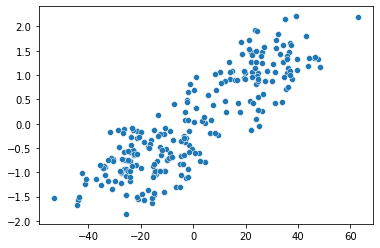

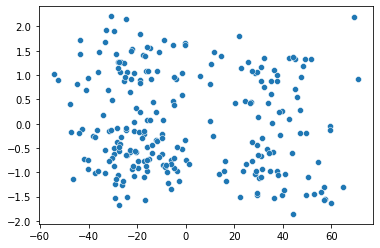

(240, 6)
(240, 441)
(6, 441)


In [202]:
sns.scatterplot(x=Dlsr[:,2], y=X[:,29])
plt.show()
sns.scatterplot(x=Dlsr[:,3], y=X[:,29])
plt.show()
print(Dlsr.shape)
print(X.shape)
print(Alsr.shape)

# Task 2.2

C:\Users\Tony Zhou\AppData\Local\Programs\Python\Python37-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


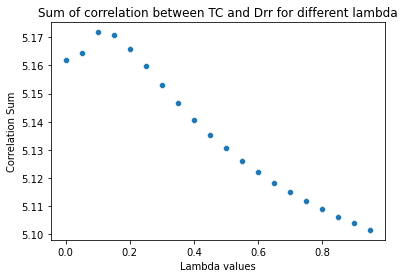

In [203]:
from scipy import stats

V = 441

def obtain_Drr(True_D, _lambda, V):
    lambda_hat = V*_lambda
    True_DT = np.transpose(True_D)
    Arr = np.abs(np.matmul(np.matmul(np.linalg.inv(np.matmul(True_DT, True_D)+lambda_hat*np.eye(6)), True_DT), X))
    Drr = np.matmul(X, np.transpose(Arr))
    return Drr


def corr_vectors(True_D, Estimated_D):
    c_vector = []
    for i in range(0,6):
        max_corr = 0
        for j in range(0,6):
            corr, p = stats.pearsonr(True_D[:,i], Estimated_D[:,j])
            corr = np.abs(corr)
            if (corr>max_corr):
                max_corr = corr
                col = j
        c_vector.append(max_corr)
    return c_vector


sum_ctrrs = []
for _lambda in np.arange(0, 1, 0.05):
    Drr = obtain_Drr(D, _lambda, V)
    ctrr = corr_vectors(D, Drr)
    sum_ctrr = np.sum(ctrr)
    sum_ctrrs.append(sum_ctrr)

sns.scatterplot(np.arange(0,1,0.05), sum_ctrrs)
plt.xlabel("Lambda values")
plt.ylabel("Correlation Sum")
plt.title("Sum of correlation between TC and Drr for different lambda")
plt.show()


# Note when lambda = 0, this is same as Dlsr, hence pick any lambda where 
# its greater than first point
# Hence we choose lambda = 0.1


Also, for λ = 1000, plot first vector from
ARR and the corresponding vector from ALSR, Do you find all values in a
1
RR shrinking
towards zero

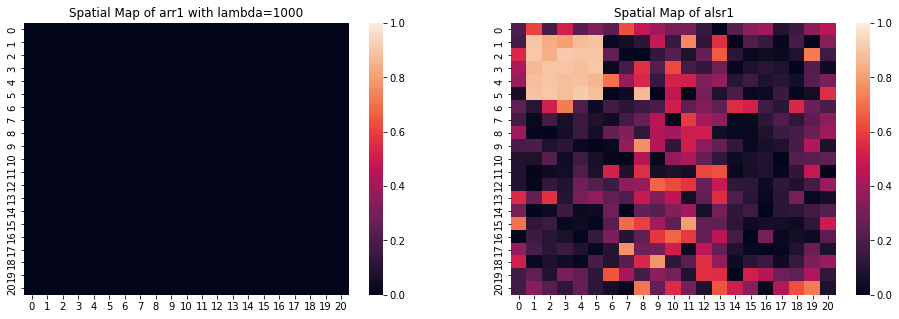

In [258]:
_lambda = 1000
V = 441
lambda_hat = V*_lambda

Arr = np.abs(np.matmul(np.matmul(np.linalg.inv(np.matmul(DT, D)+lambda_hat*np.eye(6)), DT), X))
arr1 = np.reshape(Arr[0,:], (21,21), order='F')
alsr1 = np.reshape(Alsr[0,:], (21,21), order='F')

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.title("Spatial Map of arr1 with lambda=1000")
sns.heatmap(arr1,vmin=0, vmax=1)
plt.subplot(1,2,2)
plt.title("Spatial Map of alsr1")
sns.heatmap(alsr1,vmin=0, vmax=1)
plt.savefig("plots/alsr1 and arr1")
plt.show()

# Yes, shrinks towards 0


# Task 2.3

In [303]:

V=441
N=240
nsrcs = 6
x1=21
x2=21

def gen_new_X():
    SM = np.genfromtxt('data/SM.csv', delimiter=',')

    TC_noise = np.random.normal(scale=np.sqrt(0.25), size=(240, 6))
    SM_noise = np.random.normal(scale=np.sqrt(0.015) ,size=(6, 441))

    new_TC = np.add(D, TC_noise)
    new_SM = np.add(SM, SM_noise)

    new_X = np.matmul(new_TC, new_SM)
    return stats.zscore(new_X, axis=0)

def gen_new_Alr(rho, X, D):
    DT = np.transpose(D)
    norm = norm = np.linalg.norm(np.matmul(D, DT), ord=1)
    step = 1/(norm*1.1)
    thr = rho*N*step
    Ao = np.zeros((nsrcs, 1))
    A = np.zeros((nsrcs, 1))
    Alr = np.zeros((nsrcs, x1*x2))

    for k in range(0, x1*x2):
        A = Ao + step*np.matmul(DT, np.transpose(np.matrix(X[:,k]))- np.matmul(D, Ao))
        A = (1/(1+thr))*np.multiply(np.sign(A),np.maximum(np.zeros((nsrcs,1)), np.abs(A)-thr))
        for i in range(1, 11):
            Ao = A
            A = Ao + step*np.matmul(DT, np.transpose(np.matrix(X[:,k]))- np.matmul(D, Ao))
            A = (1/(1+thr))*np.multiply(np.sign(A),np.maximum(np.zeros((nsrcs,1)), np.abs(A)-thr))
        Alr[:,k] = np.transpose(A)
    return Alr


MSEs = []
for rho in np.arange(0,1.01, 0.05):
    avg_MSE = []
    for i in range(0, 10):
        new_X = gen_new_X()
        new_Alr = gen_new_Alr(rho, new_X, D)
        new_Dlr = np.matmul(new_X, np.transpose(new_Alr))
        predicted_X = np.matmul(new_Dlr,new_Alr)
        error = new_X - predicted_X
        MSE = np.sum(error**2)/(N*V)

        diff_norm = np.linalg.norm(error, 'fro')
        MSE = diff_norm*diff_norm/(N*V)
        avg_MSE.append(MSE)
    MSEs.append(np.mean(avg_MSE))
MSEs



[2982.0348205723735,
 1642.156335121525,
 957.4680689940509,
 530.8731685304643,
 290.658897277936,
 155.00843975424723,
 79.00555740652023,
 37.03793782449118,
 16.897704311629198,
 6.682702894231781,
 2.476866377285784,
 0.8099778743781633,
 0.46051565549443624,
 0.5607157929989337,
 0.7465297169774441,
 0.8890506543028558,
 0.9658778973231442,
 0.9969133132790431,
 0.9999888757095592,
 0.9999999999999993,
 1.0000000000000004]

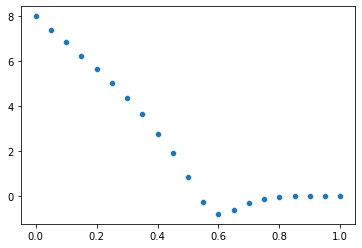

In [241]:
sns.scatterplot(x=np.arange(0,1.01, 0.05), y=np.log(MSEs))

plt.show()

Lowest point at rho=0.5, is it okay to select this value??
When did it start increasing again?
Maybe show one of the 441x1 Alr at rho=0.5 vs rho=1 to show that coefficients hasnt been fully shrunken hence ok to choose

# Task 2.4

In [245]:
rho=0.6

Alr = gen_new_Alr(rho, X, D)
Dlr = np.matmul(X, np.transpose(Alr))

cslr = corr_vectors(np.transpose(SM), np.transpose(Alr))
ctlr = corr_vectors(D, Dlr)

csrr = corr_vectors(np.transpose(SM), np.transpose(Arr))
ctrr = corr_vectors(D, Drr)

5.43102029516866 5.101475786134694
5.058255396699652 3.0554552954099896


Plotting RR and LR

C:\Users\Tony Zhou\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


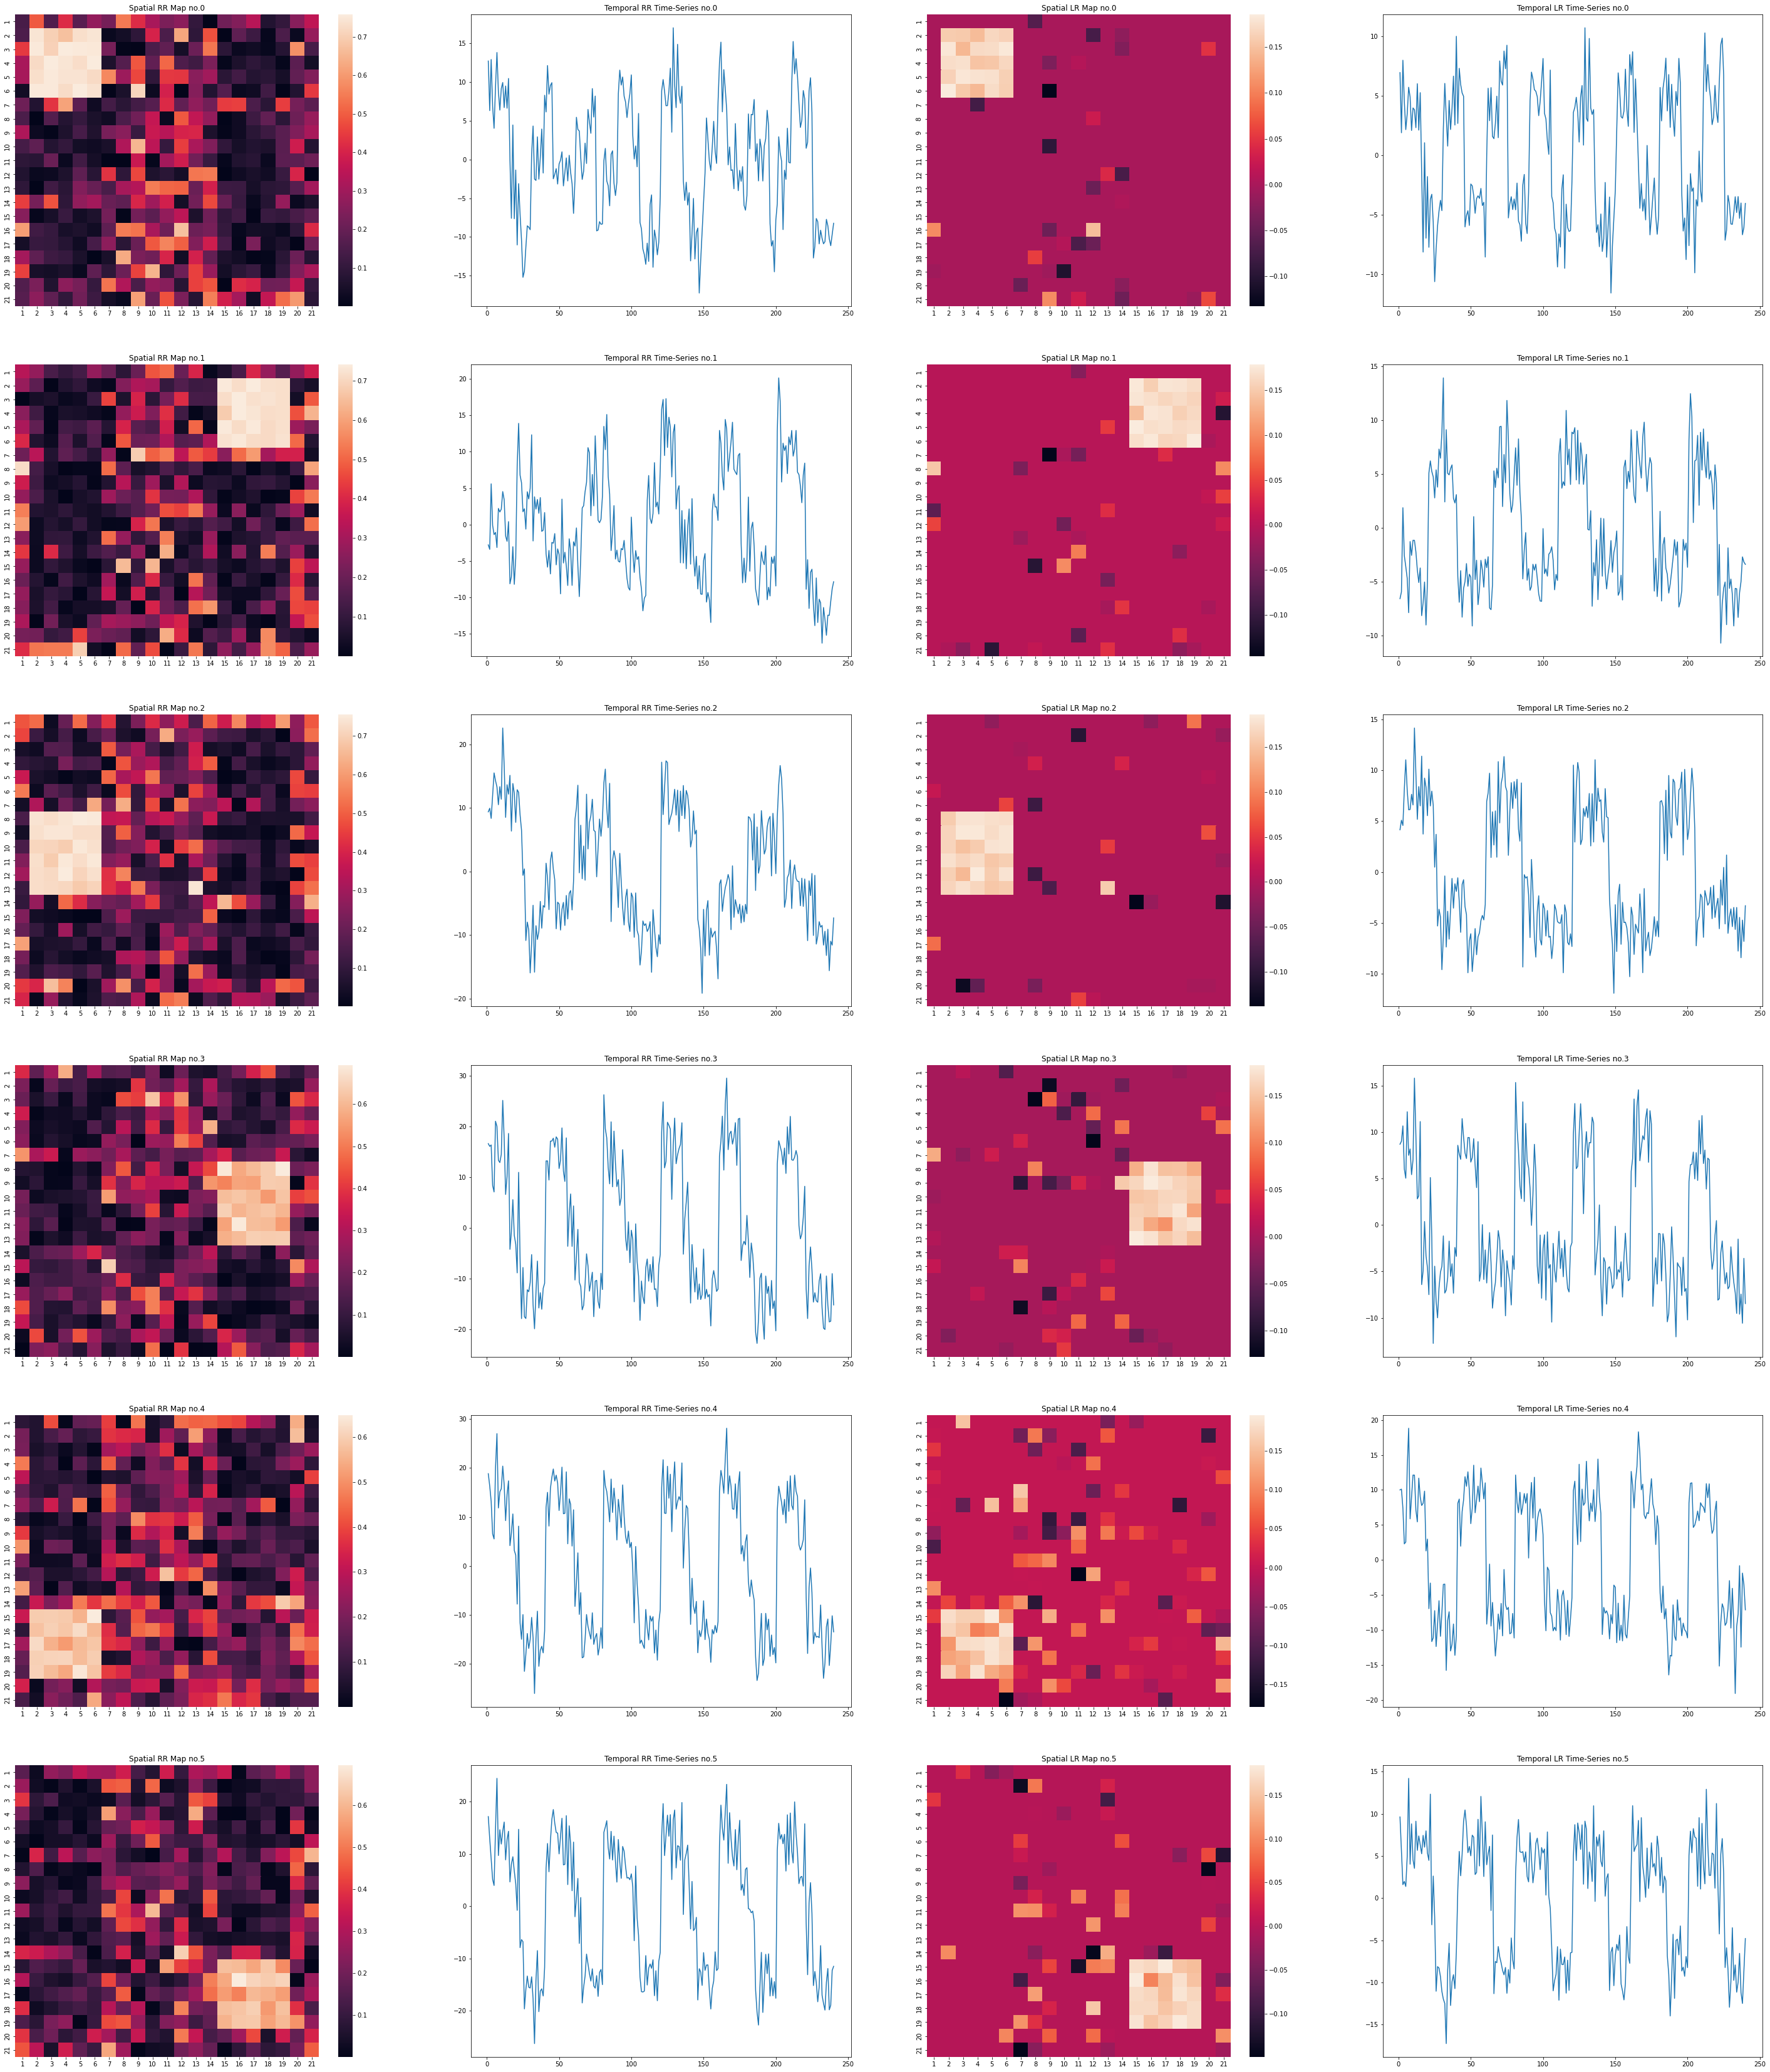

In [262]:
_lambda = 0.1
V = 441
lambda_hat = V*_lambda
Arr = np.abs(np.matmul(np.matmul(np.linalg.inv(np.matmul(DT, D)+lambda_hat*np.eye(6)), DT), X))

fig, axs = plt.subplots(6, 4, figsize=(50,60))
for i in range(0, 6):
    Arr_pixels = np.reshape(Arr[i,:], (21,21), order='F',)
    sns.heatmap(Arr_pixels, yticklabels=range(1,22), xticklabels=range(1,22), ax=axs[i, 0])
    axs[i, 0].set_title(f'Spatial RR Map no.{i}')

    sns.lineplot(x=range(1,241), y=Drr[:,i],  ax=axs[i, 1])
    axs[i, 1].set_title(f'Temporal RR Time-Series no.{i}')
    
    Alr_pixels = np.reshape(Alr[i,:], (21,21), order='F')
    sns.heatmap(Alr_pixels, yticklabels=range(1,22), xticklabels=range(1,22),  ax=axs[i, 2])
    axs[i, 2].set_title(f'Spatial LR Map no.{i}')

    sns.lineplot(x=range(1,241), y=Dlr[:,i], ax=axs[i, 3])
    axs[i, 3].set_title(f'Temporal LR Time-Series no.{i}')

fig.savefig('plots/LR vs RR plots')
fig.show()
# Seems like theres more white spots for RR than LR
# RR shrinks coefficients towards zero with same factor so doesn't eliminate false positives
# While LR is able to shrink less important coefficients by shrinking them towards zero


    

# Task 2.5
Estimate PCs of the TCs and plot their eigen values. For which PC the eigen value
is the smallest? Plot the regressors in Z and source TCs side by side. Did you notice
deteriorated shape of PCs? Why the shape of TCs has been lost? Now keeping all
components in Z apply lasso regression on X using ρ = 0.001 and then Plot the results
of DP CR and AP CR side by side (note that AP CR = B and your regressors are in Z
(PCs of the TCs)). Did you notice the inferior performance of PCR compared to the
other three regression models? Why is that so?

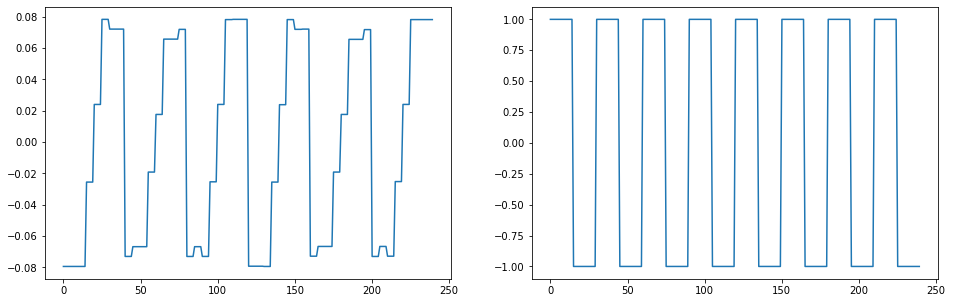

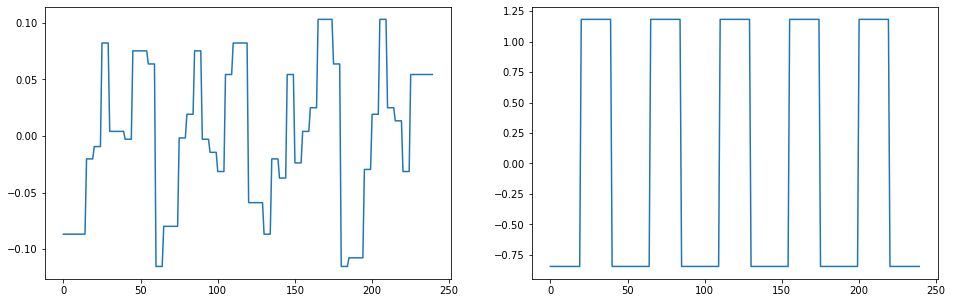

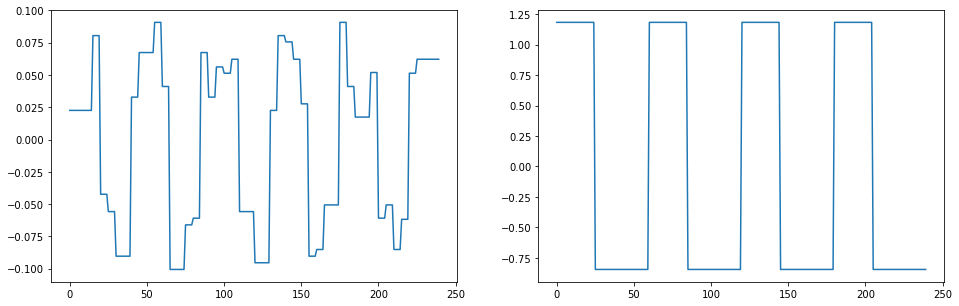

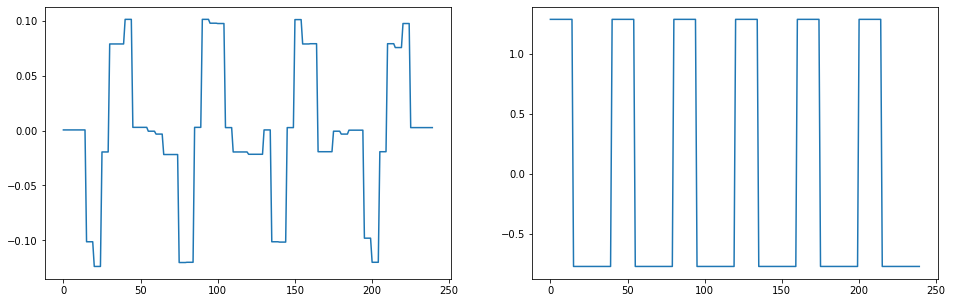

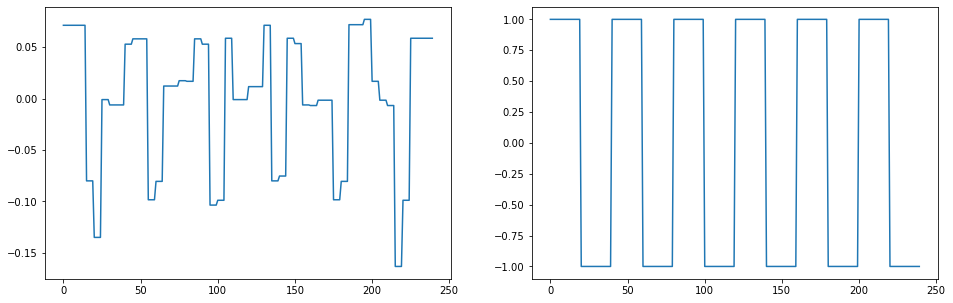

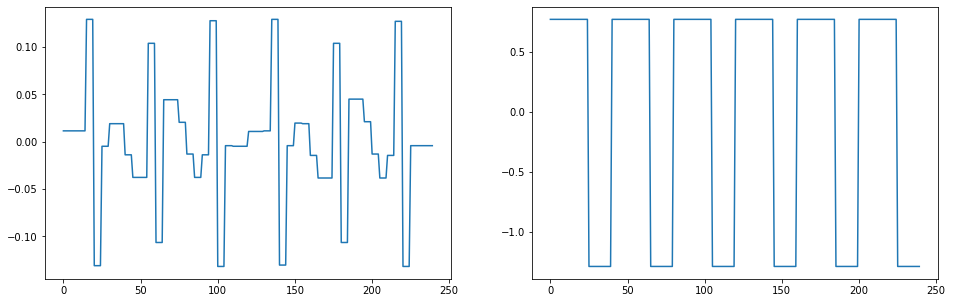

In [301]:
Z, eigval, vt = np.linalg.svd(D, full_matrices=1)

Z = Z[:,0:6]

for i in range(0,6):
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plot = sns.lineplot(x=range(0,240), y=Z[:,i])
    plt.subplot(1,2,2)
    plot = sns.lineplot(x=range(0,240), y=D[:,i])
# print(s.shape)
# print(vt.shape)

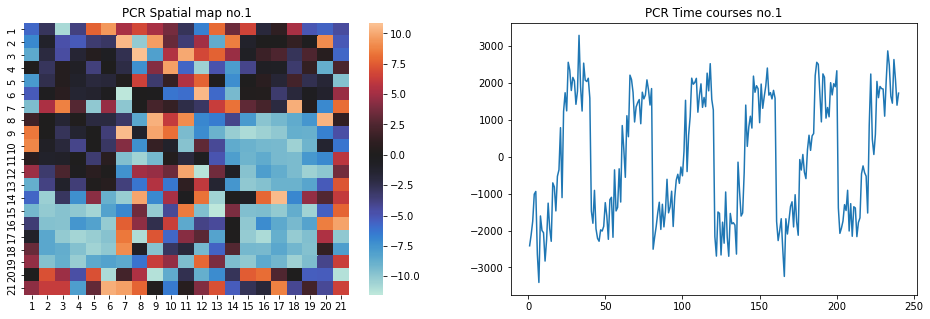

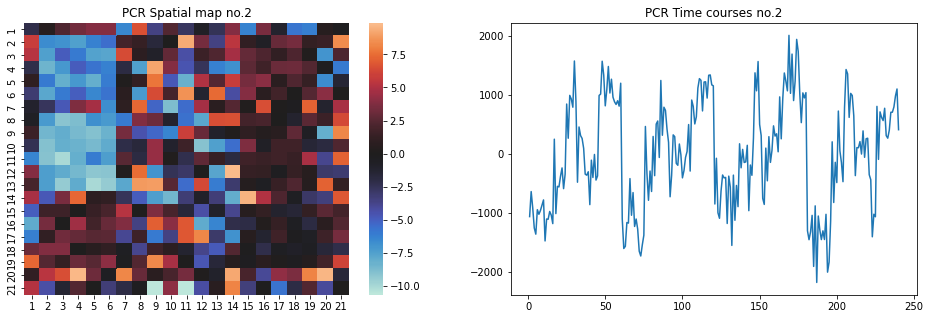

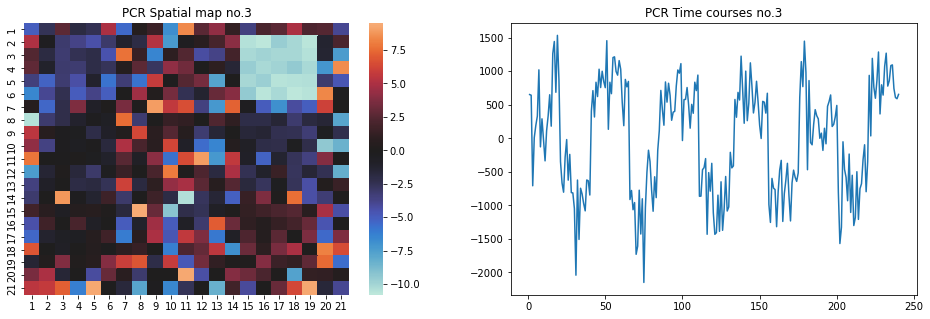

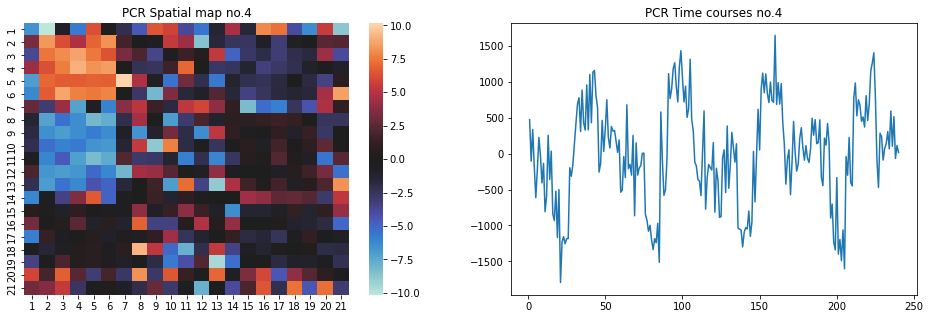

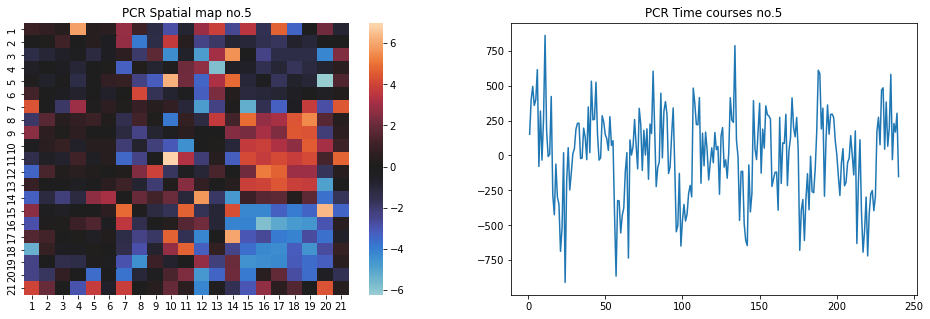

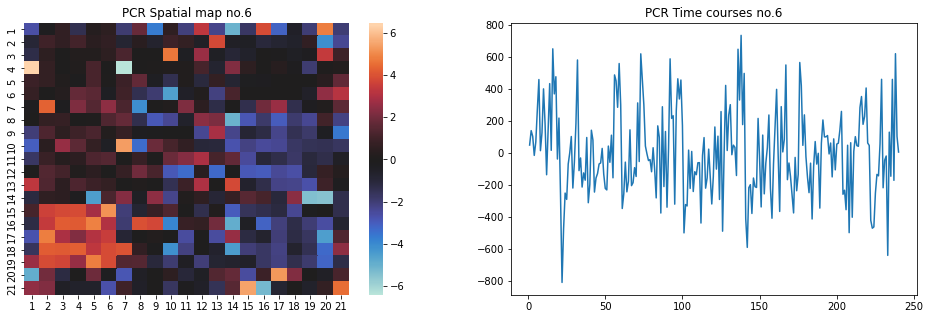

In [305]:
rho=0.001

Apcr = gen_new_Alr(rho, X, Z)
Dpcr = np.matmul(X, np.transpose(Apcr))

for i in range(0, 6):
    retrieved_SM = np.reshape(Apcr[i,:], (21,21), order='F')
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)  
    plt.title(f'PCR Spatial map no.{i+1}')
    sns.heatmap(retrieved_SM, center=0, yticklabels=range(1,22), xticklabels=range(1,22))
    plt.subplot(1,2,2)
    plt.title(f'PCR Time courses no.{i+1}')
    sns.lineplot(x=range(1,241),y=Dpcr[:,i])
    # plt.savefig(f'plots/retrieved sources {i+1}')
    plt.show()